# COCS2673 Assignment 2 P1A - Cancer detection in images

In [1]:
#!pip install tensorflow

In [2]:
#import zipfile
#with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#   zip_ref.extractall('./')

In [3]:
#!pwd

In [33]:
import tensorflow as tf
#AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import pandas as pd

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


tf.__version__

'2.4.1'

# Read Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly



In [5]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [6]:
mainData = mainData.sample(2000)   # Sampling used for inital model development
#mainData = mainData.append(extraData, ignore_index=True)

In [7]:
mainData = mainData.sample(frac=1).reset_index(drop=True)

In [8]:
mainData.shape[0]

2000

Update Categorical Data types

In [9]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['cellType'], axis=1,inplace=True)
mainData.drop(['cellTypeName'], axis=1,inplace=True)


**There are no missing values in the datasets.**

In [10]:
def BinBreakdown(desc, data):
    neg, pos = np.bincount(data)
    total = neg + pos
    print('{} Class Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(desc, total, pos, 100 * pos / total))

In [11]:
BinBreakdown('Input Data', mainData.isCancerous)

Input Data Class Data:
    Total: 2000
    Positive: 820 (41.00% of total)



# Train/Validation/Test Split on Patients

### Add classification class

In [12]:
mainData['isCancerous'] = mainData['isCancerous'].astype('str')

### Split Data into Train/Validate/Test
For test and training data split via person.
This assumes that if a person has cancer or not, then would the images for that person have cancer.
Also different cell types per person would be used for validation/testing.

In [13]:
# Get list of patients and observation counts
# Allocate approc 25% of data for Validation and Testing - of that 60%/40% for validation/test split.
TEST_RATIO = 0.10
VAL_RATIO = 0.15


In [14]:
# Split train tests by ratios
# Select random patients until the number of images for 
# each patient sums to the number of records require

np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
patientRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(patientRec.keys())

# Loop through selecting a patient at random summing the number of images they have
# until the count of images crosses is more than required number

testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = patientRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = patientRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [15]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [16]:
totalRecs = mainData.shape[0]
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])

print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))
print("Train data : {:.2f}%, Val Data: {:.2f}%, Test Data: {:.2f}%".format(
    100 * trainData.shape[0] / totalRecs, 100 * valData.shape[0]/totalRecs, 100 * testData.shape[0]/totalRecs))

Train data : 1459, Val Data: 303, Test Data: 238
Train data : 72.95%, Val Data: 15.15%, Test Data: 11.90%


In [17]:
BinBreakdown('Train', trainData.isCancerous)
BinBreakdown('Validation', valData.isCancerous)
BinBreakdown('Test', testData.isCancerous)

Train Class Data:
    Total: 1459
    Positive: 563 (38.59% of total)

Validation Class Data:
    Total: 303
    Positive: 128 (42.24% of total)

Test Class Data:
    Total: 238
    Positive: 129 (54.20% of total)



([0, 1], <a list of 2 Text xticklabel objects>)

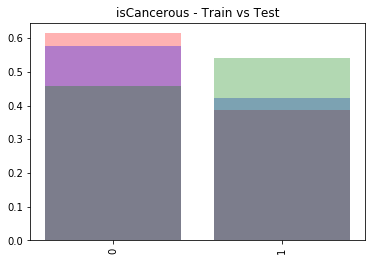

In [18]:
plt.bar(
    trainData.isCancerous.value_counts().index.astype(str), 
    trainData.isCancerous.value_counts().values/np.sum(trainData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='r')

plt.bar(
    valData.isCancerous.value_counts().index.astype(str), 
    valData.isCancerous.value_counts().values/np.sum(valData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='b')

plt.bar(
    testData.isCancerous.value_counts().index.astype(str), 
    testData.isCancerous.value_counts().values/np.sum(testData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='g')

plt.title('isCancerous - Train vs Test')
plt.xticks(rotation='vertical')

**Observations:**
1. Train/Validation/Test data distributions sets have similar distributions

# Images
27x27 RGB 

# Questions
* Results are the same for all models - looks bad but I can work out why
* accuracy jumps around but how to set learning rate?

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training add Data Augmentation to assist with any overfitting (see Sirinukunwattana et al 2016)
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    data_format='channels_last',
    #rotation_range=90, 
    #width_shift_range=0.1,
    #height_shift_range=0.1, 
    #brightness_range=[0.5,1.5]
)

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1459 validated image filenames belonging to 2 classes.
Found 303 validated image filenames belonging to 2 classes.
Found 238 validated image filenames belonging to 2 classes.


### Utility Functions

In [20]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [21]:
def PlotModelFitHistory(mh):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(mh.history['loss'], 'r--')
    plt.plot(mh.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(mh.history['categorical_accuracy'], 'r--')
    plt.plot(mh.history['val_categorical_accuracy'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


In [22]:
def PlotConfusionMatrix(test, pred):
    cm = confusion_matrix(test, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Model Development

In [23]:
def CompileModel(model):
    opt = tf.keras.optimizers.Adagrad()
    model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy', 'accuracy'])
    

In [24]:
early_stopping_monitor = EarlyStopping(patience=10, monitor='val_categorical_accuracy')

def FitModel(model):

    print('start ', datetime.datetime.now().strftime("%H:%M:%S"))
    now = datetime.datetime.now()

    fit_history = model.fit(train_generator, validation_data = validation_generator, 
                            callbacks=[early_stopping_monitor], epochs=10000, verbose=1)

    print('stop ', datetime.datetime.now().strftime("%H:%M:%S"))
    print("Took = ", datetime.datetime.now() - now)
    
    return fit_history

In [25]:
def PredictModel(model):
    batch_size_ = 1
    y_pred = list()
    y_test = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            yp = model_reg.predict(x, verbose=0)
            yp = np.argmax(yp, axis = 1)
            yt = np.argmax(y, axis = 1)
            y_pred = y_pred + yp.tolist()
            y_test = y_test + yt.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                break
                
    return (y_test, y_pred)

# Base Model

In [26]:
INPUT_DIM = (27,27,3)
OUTPUT_CLASSES = 2


In [27]:
model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [28]:
CompileModel(model_reg)

In [29]:
history_reg = FitModel(model_reg)

start  17:32:25
Epoch 1/10000
46/46 [==============================] - 3s 47ms/step - loss: 0.7296 - categorical_accuracy: 0.5645 - accuracy: 0.5645 - val_loss: 0.6283 - val_categorical_accuracy: 0.5809 - val_accuracy: 0.5809
Epoch 2/10000
46/46 [==============================] - 1s 21ms/step - loss: 0.6463 - categorical_accuracy: 0.6437 - accuracy: 0.6437 - val_loss: 0.6156 - val_categorical_accuracy: 0.5809 - val_accuracy: 0.5809
Epoch 3/10000
46/46 [==============================] - 1s 24ms/step - loss: 0.5730 - categorical_accuracy: 0.7001 - accuracy: 0.7001 - val_loss: 0.5866 - val_categorical_accuracy: 0.6073 - val_accuracy: 0.6073
Epoch 4/10000
46/46 [==============================] - 1s 25ms/step - loss: 0.5209 - categorical_accuracy: 0.7457 - accuracy: 0.7457 - val_loss: 0.5209 - val_categorical_accuracy: 0.7921 - val_accuracy: 0.7921
Epoch 5/10000
46/46 [==============================] - 1s 24ms/step - loss: 0.5187 - categorical_accuracy: 0.7501 - accuracy: 0.7501 - val_loss:

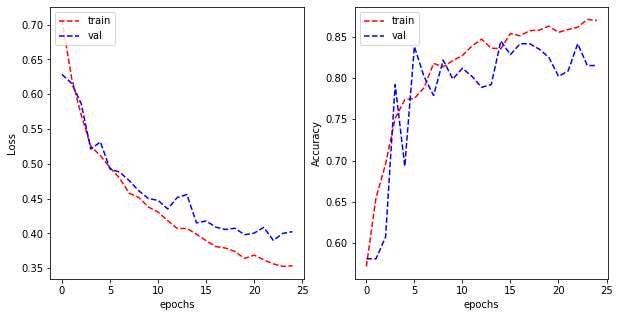

In [30]:
PlotModelFitHistory(history_reg)

In [31]:
(test_y, pred_y) = PredictModel(model_reg)

In [34]:
print("Accuracy score: ", accuracy_score(test_y, pred_y))
print("F1 score: ", f1_score(test_y, pred_y, average='macro'))

print(classification_report(test_y, pred_y, zero_division=0))

Accuracy score:  0.8450803495912038
F1 score:  0.8450548532187865
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      3247
           1       0.91      0.79      0.85      3847

    accuracy                           0.85      7094
   macro avg       0.85      0.85      0.85      7094
weighted avg       0.85      0.85      0.85      7094



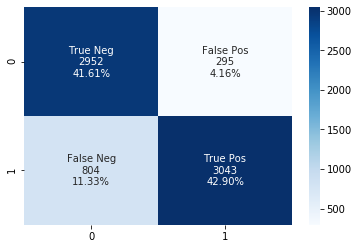

In [35]:
PlotConfusionMatrix(test_y, pred_y)

## 5. VGG 2 with simplified convolutions
* We have 20k images so that should be ok for training
* image size is small so down scaling is not too beneficial
* after 40 epics so could stop early 
* over fitting so reduce the number of convolutions
* Given number of images, data augmentation probably not required


In [36]:
model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])


In [37]:
CompileModel(model_VGG_2)

In [38]:
history_VGG_2 = FitModel(model_VGG_2)

start  17:35:51
Epoch 1/10000
46/46 [==============================] - 4s 80ms/step - loss: 0.6784 - categorical_accuracy: 0.5706 - accuracy: 0.5706 - val_loss: 0.6692 - val_categorical_accuracy: 0.5776 - val_accuracy: 0.5776
Epoch 2/10000
46/46 [==============================] - 3s 69ms/step - loss: 0.6448 - categorical_accuracy: 0.6339 - accuracy: 0.6339 - val_loss: 0.6649 - val_categorical_accuracy: 0.5776 - val_accuracy: 0.5776
Epoch 3/10000
46/46 [==============================] - 3s 69ms/step - loss: 0.6635 - categorical_accuracy: 0.5897 - accuracy: 0.5897 - val_loss: 0.6643 - val_categorical_accuracy: 0.5776 - val_accuracy: 0.5776
Epoch 4/10000
46/46 [==============================] - 3s 69ms/step - loss: 0.6594 - categorical_accuracy: 0.5898 - accuracy: 0.5898 - val_loss: 0.6597 - val_categorical_accuracy: 0.5776 - val_accuracy: 0.5776
Epoch 5/10000
46/46 [==============================] - 4s 76ms/step - loss: 0.6571 - categorical_accuracy: 0.5945 - accuracy: 0.5945 - val_loss:

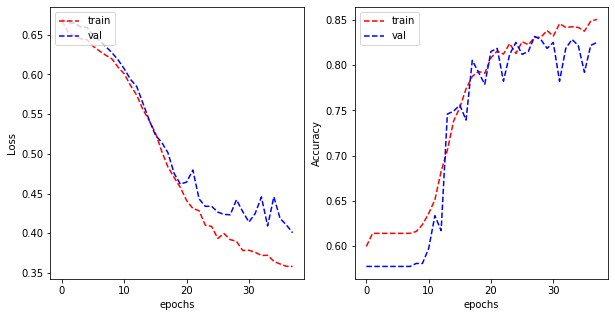

In [39]:
PlotModelFitHistory(history_VGG_2)

In [40]:
(test_y, pred_y) = PredictModel(history_VGG_2)

In [41]:
print("Accuracy score: ", accuracy_score(test_y, pred_y))
print("F1 score: ", f1_score(test_y, pred_y, average='macro'))

print(classification_report(test_y, pred_y, zero_division=0))

Accuracy score:  0.8439796495195026
F1 score:  0.8439597041957378
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      3244
           1       0.91      0.79      0.85      3832

    accuracy                           0.84      7076
   macro avg       0.85      0.85      0.84      7076
weighted avg       0.85      0.84      0.84      7076



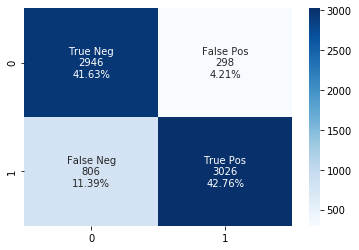

In [42]:
PlotConfusionMatrix(test_y, pred_y)

### Observations
* The model still took a long time to train
* There looks to be minimal overfitting
* Reducing the number of epochs to 50 showed minimal loss issues but accuracy was jumbled - perhaps training rate too high

*Big Issue* Still not detecting any true cases!